In [1]:
import os
import sys
#sys.path.append(os.path.join(os.getcwd(), '..'))
from ldm.data.deepfashion import DeepFashionSMPL
from ldm.util import instantiate_from_config
from einops import rearrange
import matplotlib.pyplot as plt
from collections import namedtuple
from copy import deepcopy

import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from torchvision import transforms as T
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

from ldm.data.deepfashion_inshop import DeepFashionSample
from ldm.data.segm_utils import LipSegmenter
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import pickle

In [2]:
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)
    model.eval()
    return model

In [3]:
device = 'cuda:0'
CKPT = 'logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt'
CONFIG = 'configs/deepfashion/inshop_lip_clip.yaml'

config = OmegaConf.load(CONFIG)
config['data']['params']['test']['params']['data_file'] = 'deepfashion_map.csv'
# create clip image encoder


## Instantiate text and image encoder

In [4]:
clip_image_encoder = instantiate_from_config(config['model']['params']['extra_cond_stages']['style_cond']).to(device)
text_encoder_config = {'target': 'ldm.modules.encoders.modules.FrozenCLIPTextEmbedder', 
                       'params': {'normalize': False}}
clip_text_encoder = instantiate_from_config(text_encoder_config).to(device)
config['model']['params']['extra_cond_stages']['style_cond']['target'] = 'ldm.modules.poses.poses.DummyModel'
#config['model']['params']['extra_cond_stages']['style_cond']['cond_stage_key'] = 'styles'

In [5]:
model = load_model_from_config(config, f"{CKPT}").to(device)

Loading model from logs/2023-01-31T02-39-11_inshop_lip_clip/checkpoints/epoch=000007.ckpt
Global Step: 49921
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 425.29 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Restored from models/first_stage_models/kl-f8-deepfashion/deepfashion_inshop_256.ckpt


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.self_attn.k_proj.bias', 'vision_model.encoder.layers.23.layer_norm2.weight', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.7.layer_norm1.bias', 'vision_model.encoder.layers.6.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.layer_norm1.weight', 'vision_model.encoder.layers.20.self_attn.k_proj.weight', 'vision_model.encoder.layers.11.layer_norm1.bias', 'vision_model.encoder.layers.5.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.15.mlp.fc1.weight'

In [6]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
ds = DeepFashionSample(**config['data']['params']['test']['params'])

In [7]:
def generate(model, batch, steps=200):
    
    for k, v in batch.items():
        if type(v)==torch.Tensor:
            batch[k] = batch[k].unsqueeze(0).to(device)
        else:
            batch[k] = [batch[k]]
    
    with torch.no_grad():
        images = model.log_images(batch, ddim_steps=steps, 
                                  unconditional_guidance_scale=3.,
                                  unconditional_guidance_label=["txt"])
        
    for k in images:
        images[k] = images[k].detach().cpu()
        images[k] = torch.clamp(images[k], -1., 1.)
        images[k] = rearrange(images[k].numpy(),'b c h w -> b h w c') *0.5 + 0.5
    return images


def draw_styles(style_batch):
    
    #style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']

    denorm = T.Compose([ T.Normalize(mean = [ 0., 0., 0. ],  std = [ 1/0.226862954, 1/0.26130258, 1/0.27577711 ]),
                         T.Normalize(mean = [ -0.48145466, -0.4578275, -0.40821073], std = [ 1., 1., 1. ]),      ])
    rows, cols = 2, 4
    fig, axs = plt.subplots(rows, cols)
    fig.set_figheight(8)
    fig.set_figwidth(16)
    for i, (name, style) in enumerate(zip(style_names[:-1], style_batch[:-1])):
        row = i//cols
        col = i%cols
        axs[row, col].imshow(T.ToPILImage()(denorm(style)))
        axs[row, col].set_title(name)
        axs[row, col].axis('off')
    plt.show()
            

In [8]:
import re
def convert_fname(long_name):
    #input_list = ['WOMENShortsid0000478403_4full','WOMENBlouses_Shirtsid0000311501_2side','WOMENShortsid0000478403_4full','WOMENShortsid0000478403_1front']
    input_list = long_name.replace('fashion','').split('___')
    # Define a regular expression pattern to match the relevant parts of each input string
    pattern = r'WOMEN(\w+)id(\d+)_(\d)(\w+)'

    # Use a list comprehension to extract the matching substrings from each input string, and format them into the desired output format
    output_list = [f'WOMEN/{category}/id_{id_num[:8]}/{id_num[8:]}_{view_num}_{view_desc}' for (category, id_num, view_num, view_desc) in re.findall(pattern, ' '.join(input_list))]

    # Print the resulting list of formatted strings
    return output_list

#convert_fname('fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front')
convert_fname('fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side')

['WOMEN/Blouses_Shirts/id_00003115/01_7_additional',
 'WOMEN/Blouses_Shirts/id_00003115/01_2_side']

In [9]:
src_id = 'WOMEN/Shorts/id_00004784/03_4_full.jpg'
dst_id = 'WOMEN/Shorts/id_00004784/03_1_front.jpg'

src_id = 'WOMEN/Shorts/id_00004784/03_4_full.jpg'
dst_id = 'WOMEN/Shorts/id_00004784/03_1_front.jpg'

src_batch = ds[src_id]
dst_batch = ds[dst_id]

dst_batch['txt'] = src_batch['txt']
dst_batch['styles'] = src_batch['styles']

list_jacket = ['fashionWOMENShortsid0000478403_4full___fashionWOMENShortsid0000478403_1front.png',
'fashionWOMENBlouses_Shirtsid0000311501_7additional___fashionWOMENBlouses_Shirtsid0000311501_2side.png',
               'fashionWOMENTees_Tanksid0000298802_4full___fashionWOMENTees_Tanksid0000298802_1front.png',
#'fashionWOMENTees_Tanksid0000788404_4full___fashionWOMENTees_Tanksid0000788404_2side.png',
'fashionWOMENTees_Tanksid0000397106_7additional___fashionWOMENTees_Tanksid0000397106_1front.png',
              'fashionWOMENTees_Tanksid0000664503_4full___fashionWOMENTees_Tanksid0000664503_3back.png',
              'fashionWOMENDressesid0000651901_4full___fashionWOMENDressesid0000651901_2side.png']

In [10]:
clip_transform = T.Compose([T.ToTensor(),
                           T.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), 
                                    std=(0.26862954, 0.26130258, 0.27577711))
                          ])

def get_empty_style():
    return clip_transform(np.zeros((224,224,3)))

In [11]:
text_prompt = {'hair':'dark hair'}

def mix_style(s, w, mask=[]):
    style2id = dict(zip(style_names,[x for x in range(len(style_names))]))
    text_dict = dict(zip(style_names, ['' for _ in range(len(style_names))]))
    
    for m in mask:
        s[style2id[m]] = get_empty_style()
        
    with torch.no_grad():        
        for k, v in w.items():
            text_dict[k] = v
        texts = list(text_dict.values())
        text_emb = clip_text_encoder([texts])
        
        image_emb = clip_image_encoder(s.unsqueeze(0).to(device))

        for i, text in enumerate(texts):
            if text != '':                
                image_emb[0,i] = text_emb[0,i]
                
    return image_emb.squeeze(0)


#mix_style(dst_batch['styles'], text_prompt).shape

In [272]:
men = [x.split('.')[0] for x in ds.map_df.index if x[:3]=='MEN' and 'full' in x]

In [273]:
import random


MEN/Tees_Tanks/id_00005955/06_1_front MEN/Tees_Tanks/id_00002310/02_4_full
forward text [['', '', '', '', 'blue and red stripe pattern ', '', '', '', '']]
dummy torch.Size([1, 9, 768])
Plotting: Switched to EMA weights
Data shape for DDIM sampling is (1, 4, 32, 24), eta 1.0
Running DDIM Sampling with 200 timesteps


DDIM Sampler: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 44.21it/s]

Plotting: Restored training weights


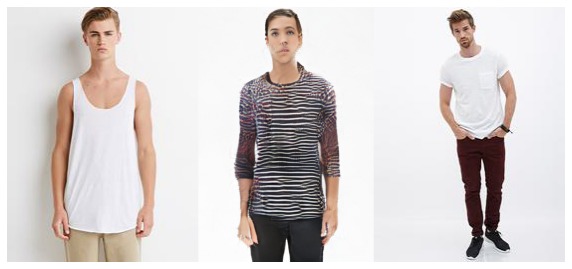

In [325]:
folder = "./figures/banner/0/"
os.makedirs(folder,exist_ok=True)
src_id = 'MEN/Tees_Tanks/id_00005955/06_1_front'

#dst_id = 'WOMEN/Dresses/id_00006168/08_4_full'
#dst_id = 'MEN/Tees_Tanks/id_00007466/08_2_side'
#dst_id = random.choice(men)
#src_id = dst_id
#for j in list_jacket[0:1]:
#_, dst_id  = convert_fname(list_jacket[1].split('.')[0])
src_batch = ds[src_id+'.jpg']
dst_batch = ds[dst_id+'.jpg']


src_image = np.uint8(((src_batch['image']+1)/2)*255)
dst_image = np.uint8(((dst_batch['image']+1)/2)*255)
src_smpl_image = Image.fromarray(np.uint8(((src_batch['smpl_image']+1)/2)*255))
dst_smpl_image = Image.fromarray(np.uint8(((dst_batch['smpl_image']+1)/2)*255))
print(src_id, dst_id)
#dst_batch['txt'] = src_batch['txt']
#dst_batch['styles'] = src_batch['styles']

text_style = {#'face': "Alice's face",
              #'hair':' dark hair',
              #'headwear': 'a red hat',
              #'background':'brown flooring',
              'top':'blue and red stripe pattern ',
              #'outer':'black long sleeve jacket',
              #'bottom':'white long pant',
              #'shoes':'black shoes',
              #'accesories':'a black watch'
                }

#style_mask = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
style_mask = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
'''
for transfer_id in [0,1]:
    src_batch['styles'][transfer_id] = dst_batch['styles'][transfer_id]
'''
src_batch['styles'] = mix_style(src_batch['styles'], text_style, mask=style_mask)

#dst_batch['smpl'][0,72:82] = src_batch['smpl'][0,72:82]
#src_batch['smpl'] = dst_batch['smpl']
#src_batch['person_mask'] = dst_batch['person_mask']

#dst_batch['styles'] = clip_image_encoder(dst_batch['styles'].unsqueeze(0).to(device)).squeeze()
#dst_batch['txt'] = 'This man wears a short sleeve -shirt with pure color patterns. The t-shirt is with cotton fabric.'
src_batch['txt'] = 'This man wears a shirt in stripe patterns. He wears a long pant.'

log = generate(model, src_batch, 200)

sample = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(log['samples'][0]*255)))
#sample.save(os.path.join(folder, j))
plt.figure(figsize=(10,10))
concat = np.hstack((src_image, np.array(sample), dst_image))

plt.imshow(concat)
plt.axis('off')
plt.show()



In [316]:
name = 'text_edit_4'
path = os.path.join(folder, name+'.png')
assert not os.path.isfile(path)
sample.save(path)

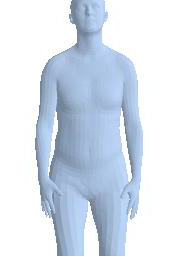

In [60]:
src_smpl_image = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(((src_batch['smpl_image']+1)/2)*255)))
src_smpl_image

In [33]:
dst_batch['txt']

['This man wears a tank tank top with pure color patterns. The tank top is with cotton fabric. The neckline of the tank top is crew.']

In [160]:
src_name = os.path.join(folder, src_id.replace('/','-')+'.png')
dst_name = os.path.join(folder, dst_id.replace('/','-')+'.png')
T.CenterCrop(size=(256, 176))(Image.fromarray(src_image)).save(src_name)
T.CenterCrop(size=(256, 176))(Image.fromarray(dst_image)).save(dst_name)

src_smpl_image.save(os.path.join(folder,'src_smpl.png'))

In [ ]:
draw_styles(dst_batch['styles'][0])

In [ ]:
style_names = ['face', 'hair', 'headwear', 'background', 'top', 'outer', 'bottom', 'shoes', 'accesories']
style2id = dict(zip(style_names, [i for i in range(len(style_names))]))


#dst_id = 'MEN/Tees_Tanks/id_00005955/06_1_front'
#dst_id = 'WOMEN/Dresses/id_00000269/13_7_additional'
dst_id = 'WOMEN/Jackets_Coats/id_00001313/02_4_full'
#dst_id = 'fashionWOMENDressesid0000182607_2side'
#dst_id = convert_fname(dst_id)[0]

#src_id = 'MEN/Sweaters/id_00000702/06_7_additional'
#src_id = 'WOMEN/Pants/id_00003761/01_7_additional'
src_id = 'WOMEN/Jackets_Coats/id_00000187/10_7_additional'
#src_id = 'fashionWOMENDressesid0000182607_2side'
#src_id = convert_fname(src_id)[0]

src_batch = ds[src_id+'.jpg']
dst_batch = ds[dst_id+'.jpg']
print(src_id, dst_id)

src_image = (((src_batch['image']+1)/2).numpy()*255).astype(np.uint8)
dst_image = (((dst_batch['image']+1)/2).numpy()*255).astype(np.uint8)

dst_batch['txt'] = src_batch['txt']
#dst_batch['txt'] = \
#'The upper clothing is sleeveless, cotton fabric and solid color patterns. It has a round neckline. The outer clothing the lady wears is sleeveless with denim and solid color patterns. This person wears a ring. There is an accessory on her wrist.'

#transfer = ['headwear', 'top', 'outer', 'bottom','shoes', 'accesories']
transfer = ['outer', 'headwear']
transfer_id = [style2id[x] for x in transfer]
for t in transfer_id:
    dst_batch['styles'][transfer_id] = src_batch['styles'][transfer_id]

log = generate(model, dst_batch, 200)

sample = T.CenterCrop(size=(256, 176))(Image.fromarray(np.uint8(log['samples'][0]*255)))

concat = np.hstack((dst_image, np.array(sample), src_image))
#sample.save(os.path.join(folder, j))
plt.figure(figsize=(12,6))
plt.imshow(concat)
plt.axis('off')
plt.show()


In [ ]:
idx = 4
folder = f"./figures/transfer/{idx}"
os.makedirs(folder,exist_ok=True)

type_name = 'texture'
#type_name = 'all'
fname = os.path.join(folder, f'dst_{idx}_{type_name}.png')

override = True
if not os.path.isfile(fname) or override:
    sample.save(fname)
    print('save ', fname)
else:
    print("File exists")